In [50]:
from metro_utils import graph, extract_stations, pairs2rails, subsets, total_distance, gen_distance_matrix, graph_x
from station import Station
from city import City
from collections import defaultdict as dd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import gurobipy as gp
from gurobipy import GRB

F mild changes to base classes:

- `graphs(..., fix_aspect=False)` optional arg to stop scaling of the visuals; and addition of low-quality station id labels
- `__repr__` for station is slightly different, was getting confused if I was dealing with 0 or Station 0

Other key points:

- Test cases in json file, I'll add to this but so far the main ones are `hexagon`, `loop_feasibility` and the `_cluster` family. See how-to import in new notebook


# Stage 0
TSP

$$\begin{aligned}
&z=\min \sum_{i=1}^{n} \sum_{j=1}^{n} c_{i j} x_{i j} \\
&\text { s.t. } \\
&\sum_{j=1}^{n} x_{i j}=1, \quad i \in I, \\
&\sum_{i=1}^{n} x_{i j}=1, \quad j \in I, \\
&\sum_{i \in S}\sum_{j \in S} x_{ij} \leq |S|-1, \qquad S \subset I, 2 \leq |S| \leq n-1, \\
&x_{i j} \in\{0,1\}, \quad i, j=1, \ldots, n.
\end{aligned}$$

In [51]:
# Load test cases
# Highly recommend https://www.mathsisfun.com/data/cartesian-coordinates-interactive.html for creating these easily

from json import load

ignore_fields = ["description", "comment", "source"]
def filter_ignore(d):
    return {k: v for k, v in d.items() if k not in ignore_fields}

with open("test_cases.json", "r") as f:
    tests = load(f, object_hook=filter_ignore)

In [52]:
# Choose problem to use in code below
test_choice = "force_rail_overlap"
locations = tests[test_choice]["locations"]
N_STATIONS = len(locations)
kinds = tests[test_choice]["kinds"]

city = City(**tests[test_choice])
stations = city.stations

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 47 rows, 36 columns and 210 nonzeros
Model fingerprint: 0xb2c6640b
Variable types: 0 continuous, 36 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 23.3137085
Presolve removed 0 rows and 6 columns
Presolve time: 0.00s
Presolved: 47 rows, 30 columns, 210 nonzeros
Variable types: 0 continuous, 30 integer (30 binary)

Root relaxation: objective 1.965685e+01, 14 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                      19.6568542    0.00000   100%     -    0s
     0     0          -    0        19.65685   19

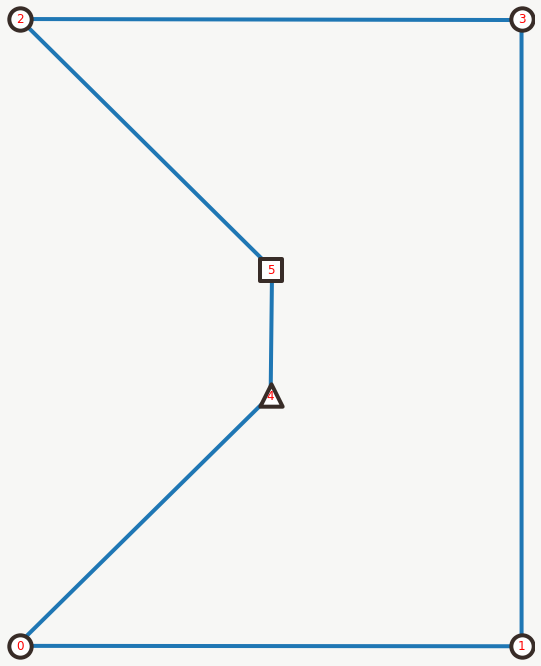

In [53]:
def tsp(city, verbose=True):
    
    n_stations = len(city.stations)
    
    dist = gen_distance_matrix(city)
    
    S = list(range(n_stations))
    subs = subsets(S)
    
    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)
    
    x = m.addVars(n_stations, n_stations, vtype=GRB.INTEGER, name="x")

    m.setObjective(gp.quicksum(dist[s1, s2]*x[s1, s2] for s1 in S for s2 in S if s1 != s2), GRB.MINIMIZE)

    # leave each station only once
    m.addConstrs(gp.quicksum(x[s1, s2] for s1 in S if s1 != s2 ) == 1 for s2 in S)
    # enter each station only once
    m.addConstrs(gp.quicksum(x[s1, s2] for s2 in S if s1 != s2 ) == 1 for s1 in S)
    # Subtour elimination constraints
    for sub in subs:
        m.addConstr(gp.quicksum(x[s1, s2] for s1 in sub for s2 in sub if s1 != s2) <= len(sub) - 1)

    m.optimize()
    
    return m
    
m = tsp(city)
best = pairs2rails([extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6])
graph(stations, best, equal_aspect=True)

## Stage 2 - MIP Approach

In [54]:
def demand_by_centrality(stations, C=3):
    """Simple proxy demand for testing the framework
    # d = Cexp(-norm_2(rescaled(s - map_midpoint)))
    # Rescaled(s) = s' is s.t. norm_1(s') <= 1
    # And map_midpoint = midpoint/center of the minimal bounding box for the stations
    #
    # ASSUMES:
    # That more central stations (by how MM generates its worlds) get/need more traffic
    """
    import math
    lb = min([s.x for s in stations])
    rb = max([s.x for s in stations])
    db = min([s.y for s in stations])
    ub = max([s.y for s in stations])

    cx = (lb+rb)/2
    cy = (db+ub)/2
    d = np.zeros([len(stations)])
    for i, s in enumerate(stations):
        d[i] = C*math.exp(-math.sqrt(((s.x-cx)/(rb-lb))**2 + ((s.y-cy)/(ub-lb))**2))
    return d

## SDVRP - Based Implementation

*Done, but needs cleaning, and may not be most powerful MIP model possible*

**Origin**: Archetti et al.'s Tabu search paper <a href="https://www.jstor.org/stable/25769283">here</a> though it is expanded on in **The Split Delivery Vehicle Routing Problem: A Survey** (Archetti et al.) <a href=" https://www-or.amp.i.kyoto-u.ac.jp/ramp2006/paper/2-1.pdf">here</a>

### Modifications made to the SDVRP model above:

0. I have been setting 'demands' to be inversely proportional to the 'centre' of the city network; this is to introduce higher-demand cities in an attempt to promote crossings.
1. Added a single 'dummy depot' from which all vehicles must leave and enter. This is to detach from 'specified/fixed depot' concept.
2. Added extra constraints to discourage self-joins (could probably merge into another constraint)
3. Added extra constraints to enforce that all vehicles must leave, and enter, dummy depot exactly once
4. Switched from DFJ SEC's to MTZ SEC's; I feel it is easier to work with when it comes to allowing loops within a route, and furthermore avoids exponentially many constraints
5. Modified MTZ SEC to 'allow' a subtour-forming join IF that node would connect directly to the dummy depot

> (Refresher: MTZ SEC's) $u_i − u_j+ px_{ij} \leq p − 1\quad\forall i,j \in V$ (here $p$ = `N_STATIONS`)

> (What I used) $u_i^{[k]} − u_j^{[k]}+ px_{ij}^{[k]} \leq p − 1 + px_{jD}^{[k]}\quad\forall i,j \in V,\ k\in D$

- Idea: if (i -> j), if j is not the last trainstop prior to a depot, then it's just ordinary MTZ but per-route
- If however (i -> j) and (j -> depot) then (because we'll have u[j,k] = 0 < u[i,k]) we add in p again 

6. Capacities of vehicles/trains are homogenous, but easily modifiable

In [55]:
def sdvrp(city, verbose=True):
    
    # A few modifications, but otherwise the same hyperparameters
    n = n_stations = len(city.stations)  # no. customers
    M = 4
    D = range(M) # set of vehicles
    S = list(range(n_stations))
    V = S  # customers
    DUMMY = n  # dummy depot's index
    V0 = S + [DUMMY]  # customers + depot

    Q = n  # capacities of vehicles (assumed homogenous)
    K = 1 # 3
    L = 100 # N_STATIONS - (M-1)*K
    mk = 1 # Num trains from kth depot

    # Slightly larger cost matrix, just with a row/col of zeros for the dummy depot
    cost = np.zeros([n+1,n+1])
    cost[:n,:n] = gen_distance_matrix(city) 

    # Demands. Unit demands is TSP-like if capacity Q = |S|
    # d = np.ones([n])

    # OR assign demand based on centrality. Normalise demand to ensure feasibility
    d = demand_by_centrality(city.stations, C=2)
    d = d * Q * M / d.sum()

    # Special-case: A `hexagon` demand assignment to showcase overlapping
    # d = [0.8, 8, 0.8, 8, 0.8, 0.8, 0.8]

    m = gp.Model()
    if not verbose:
        m.setParam('OutputFlag', 0)
        
    MIN_EDGES = 1  # relevant to an extra constraint that avoids short-lived train stops; Ants approach would do better here

    x = m.addVars(n_stations+1, n_stations+1, M, vtype=GRB.INTEGER, name="x") # node i --> node j on path of vehicle k
    y = m.addVars(n_stations, M, lb=0.0, name="y")  # quantity of ith site's demand satisfied by kth vehicle/route
    u = m.addVars(n_stations, M, lb=0.0, name="u")  # MTZ potentials

    m.setObjective(gp.quicksum(cost[i,j]*x[i,j,k] for i in V0 for j in V0 for k in D), GRB.MINIMIZE)

    # EDGE CONSISTENCY CONSTRAINTS
    # 2: at least one edge enters every j (including the depot)
    m.addConstrs(gp.quicksum(x[i,j,k] for i in V0 for k in D) >= 1 for j in V0)
    # 3: in == out for every node + depot, per-route basis (and hence in general)
    m.addConstrs((gp.quicksum(x[i,j,k] for i in V0) - gp.quicksum(x[j,i,k] for i in V0) == 0 for j in V0 for k in D))

    # SUBTOUR CONSTRAINTS 
    # 4_modified: SEC using MTZ
    m.addConstrs((u[i,k] - u[j,k] + n_stations*x[i,j,k] <= n_stations-1 + \
                      n_stations*x[j,DUMMY,k] for i in V for j in V if i != j for k in D))

    # DEMAND CONSTRANTS
    # 5: ith demand can only be sated by route k if there's an outbound edge from i on that path
    m.addConstrs(y[i,k] <= d[i]*gp.quicksum(x[i,j,k] for j in V0) for i in V for k in D)

    # 6: total sated demand @ i must meet demand
    m.addConstrs(gp.quicksum(y[i,k] for k in D) == d[i] for i in V)

    # 7: (MODIFIED FOR HOMOGENOUS CAPACITY) total sated demand by k cannot exceed capacity of vehicle
    m.addConstrs((gp.quicksum(y[i,k] for i in V) <= Q for k in D))

    # 8,9: Domain constraints (already handled)

    # EXTRA constraints
    # X1. No self-joins
    m.addConstrs(x[i,i,k] <= 0 for i in V0 for k in D)
    # X2. For a given k, you must (and only once) enter the dummy depot, and leave the dummy depot
    m.addConstrs(gp.quicksum(x[i,DUMMY,k] for i in V) == mk for k in D)
    m.addConstrs(gp.quicksum(x[DUMMY,i,k] for i in V) == mk for k in D)
    # X3. Perhaps obvious, but the same vehicle cannot cross the same connection twice (excluding depot here is key)
    m.addConstrs((x[i,j,k] + x[j,i,k] <= 1 for i in V for j in V for k in D))
    # X4. Routes must have more than 2 edges
    m.addConstrs((gp.quicksum(x[i,j,k] for i in V0 for j in V0) >= MIN_EDGES for k in D))

    # Experimental constraints
    # E1. If d() satisfies triangle ineq, then for a pair of routes, can only share one customer (see the Survey paper)
    # == NO EDGE SHARING
    # m.addConstrs((gp.quicksum(x[i,j,k] for k in D) <= 1 for i in V for j in V))
    # E2. (added for negative costs to stop lollygagging) 
    # total number of edges should not exceed N_STATIONS + 2*M (to allow loops)
    # m.addConstr(gp.quicksum(x[i,j,k] for i in V0 for j in V0 for k in D) <= N_STATIONS + 2*M)

    # Special case: Used for testing feasibility of a loop in "loop_feasibility" (3 here is the depot)
    #for a, b in [(3, 2), (2, 1), (1, 0), (0, 2), (2, 3)]:
    #    m.addConstr(x[a,b,0] == 1)

    m.optimize()
    
    return m
    
m = sdvrp(city)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 373 rows, 244 columns and 1788 nonzeros
Model fingerprint: 0x861e9dae
Variable types: 48 continuous, 196 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 21.1421356
Presolve removed 121 rows and 28 columns
Presolve time: 0.00s
Presolved: 252 rows, 216 columns, 1296 nonzeros
Variable types: 48 continuous, 168 integer (168 binary)

Root relaxation: objective 2.000000e+00, 68 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.00000    0    8   21.14214    2.00000  90.5%     -    0s
H    0     0                      1

In [56]:
from ast import literal_eval
SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2
DUMMY = len(city.stations)

# Modified connections definition to disquality report of dummy depot-related edges
connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] != DUMMY and literal_eval(v.varName[1:])[TARGET_IDX] != DUMMY]
display(connections)
#connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
#                  literal_eval(v.varName[1:])[0] < n]

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])
    
rail_pairs

[[<1>, <4>, 1], [<4>, <0>, 0], [<5>, <2>, 2], [<5>, <3>, 3]]

defaultdict(list,
            {1: [[<1>, <4>]],
             0: [[<4>, <0>]],
             2: [[<5>, <2>]],
             3: [[<5>, <3>]]})

In [57]:
# Flawed - cannot handle the below (hexagon-generated with negative costs)
"""
defaultdict(list,
            {0: [[<0>, <3>],
              [<1>, <4>],
              [<2>, <5>],
              [<3>, <6>],
              [<4>, <2>],
              [<5>, <1>],
              [<6>, <4>]]})"""

def modified_pairs2rails(pairs, debug=False):
    starts = [pair[0] for pair in pairs]
    ends   = [pair[1] for pair in pairs]
    
    for end in ends:
        if end not in starts:
            station = end
            break
    else:
        station = starts[0]
        
    if debug: print(station)
    
    # build the rails
    dict_pairs = dict(pairs)
    rev_pairs = {v:k for (k,v) in dict_pairs.items()}
    # rails is a list that encodes the edge sequence
    rails = [station]
    while rev_pairs:
        if debug: print(rev_pairs)
        station = rev_pairs.pop(station)
        rails.append(station)
    
    return rails[::-1]

def foolproof_pairs2rails(pairs, debug=False):
    # cheeky workaround
    from random import shuffle
    for _ in range(10):
        try:
            shuffle(pairs)
            return modified_pairs2rails(pairs, debug)
        except KeyError:
            continue
    else:
        raise KeyError()

In [58]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(foolproof_pairs2rails(pairs, debug=False))

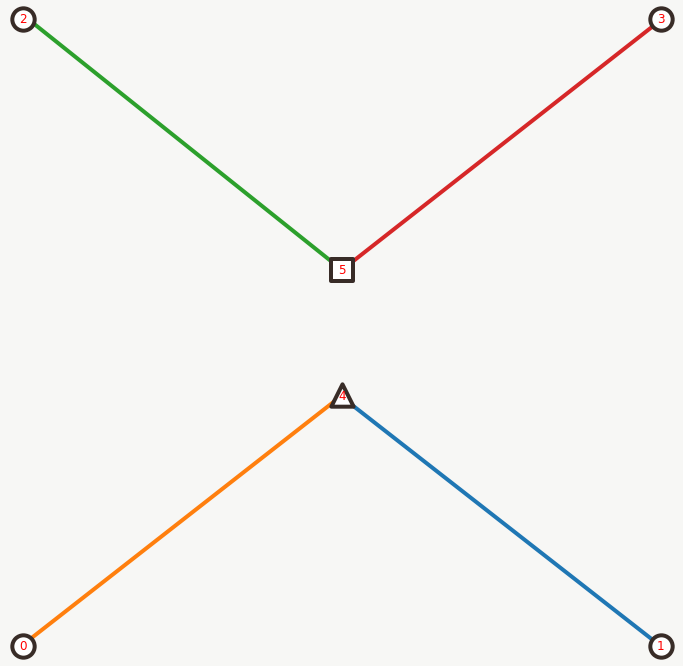

In [59]:
graph(stations, rails)

## Ant - Based Implementation (Callum WIP)

#### Meeting Notes

- GTSP (and MGTSP) exist (as does (already-multple) GVRP); they force visitation to each cluster however. Since we don't want forced visits, there's no point to this extension.
- However, maybe there is merit in quantifying inter-cluster connections per route. The GVRP formulation described at least in Kara et al. (2012) allows , which counts ICC's between clusters p and r. One could say we want minimum edge-cost, but as a secondary objective, high ICC counts overall.

In [60]:
# A few modifications, but otherwise the same hyperparameters
N = N_STATIONS  # no. customers
M = 4
D = range(M) # set of vehicles
V = list(range(N_STATIONS))  # customers
Y = list(range(N,2*N))  # dummy depots, one per station
V0 = V + Y

Q = N_STATIONS  # capacities of vehicles (assumed homogenous)
K = 2 # 3
L = 6 # N_STATIONS - (M-1)*K
mk = 1 # number of trains per route

In [61]:
# Premise: D routes/vehicles, Y depots, V stations (V0 removed)
# Routes are: y1 -> v -> ... -> v -> y2, where L & K constrain the number of v
# This is more general than nonfixed MMTSP as conservation of train entry/exit @ depots is not necessary, only in aggregate

dist = gen_distance_matrix(city)

# Redefining parameters
m = gp.Model()

# node i --> node j on path from depot k (nodes include depots)
x = m.addVars(2*N, 2*N, M, vtype=GRB.INTEGER, name="x")
# node i potential, ONLY for actual customers (not dummy) MODIFIED
u = m.addVars(N, M, vtype=GRB.CONTINUOUS, lb=0.0, name="u")

# MODIFIED
m.setObjective(gp.quicksum(dist[i, j]*x[i, j, k] for k in D for j in V for i in V), GRB.MINIMIZE)

# 2 MODIFIED: Per-route, only mk trains leave the depots
m.addConstrs(gp.quicksum(x[y,j,k] for j in V for y in Y) == mk for k in D)
# 3: MODIFIED - Each city needs at least one incoming edge
m.addConstrs(gp.quicksum(x[i, j, k] for i in V0 for k in D) >= 1 for j in V)
# 4: Per-route, per-city, edges in must equal edges out
m.addConstrs(gp.quicksum(x[i, j, k] for i in V0) - gp.quicksum(x[j, i, k] for i in V0) == 0 for k in D for j in V)
# 5: Per-route, must have mk exits to a depot
m.addConstrs(gp.quicksum(x[j,y,k] for y in Y for j in V) == mk for k in D)



# 6: UPPER-BOUND L for u. POTENTIAL CONSTRICTIONS, ESP. ENFORCING L AS A LIMIT.
#m.addConstrs(u[i,k] + (L - 2)*gp.quicksum(x[y, i, k] for y in Y) - 
#              gp.quicksum(x[i, y, k] for y in Y) <= L - 1 for i in V for k in D)
# 7: LOWER-BOUND K for u. READS LIKE FORCING END-OF-LINE STATIONS TO MEET THE LOWER BOUND
#m.addConstrs(u[i,k] + gp.quicksum(x[y, i, k] for y in Y) + \
#             (2 - K)*gp.quicksum(x[i, y, k] for y in Y) >= 2 for i in V for k in D)
# 8 IGNORED - INTERFERES WITH LOOPS IN A 'DEPOT-PER-CITY' MODEL
# m.addConstrs(x[y, i, k] + x[i, y, k] <= 1 for y in Y for i in V for k in D)
# 9: SEC enforcement, L is a nice proxy here for max potential
m.addConstrs(u[i,k] - u[j,k] + L*gp.quicksum(x[i,j,k] for k in D) <= L - 1 + \
                  N*gp.quicksum(x[j,y,k] for y in Y) for i in V for j in V if i != j for k in D)
#ORIGINALISH m.addConstrs(u[i,k] - u[j,k] + L*gp.quicksum(x[i,j,k] for k in D) + \
#              (L - 2)*gp.quicksum(x[j,i,k] for k in D) <= L - 1 + \
#                  N*gp.quicksum(x[j,y,k] for y in Y) for i in V for j in V if i != j for k in D)

# 10 MODIFIED - include depot
m.addConstrs(x[i, i, k] == 0 for i in V0 for k in D)

# EXTRA constraints (particularly given the ghost depots)
# X2. (ALREADY GOT IT HERE)
# X3. Perhaps obvious, but the same vehicle cannot cross the same connection twice (excluding depot here is key)
m.addConstrs((x[i,j,k] + x[j,i,k] <= 1 for i in V for j in V for k in D))
# X4. Routes must have more than K edges
# Note this needs adding even despite ant's K-enforcement as (8) has been excluded
m.addConstrs((gp.quicksum(x[i,j,k] for i in V for j in V) >= K for k in D))
# X5. Stations can only connect to 'their' depot (reduces symmetry)
m.addConstrs(gp.quicksum(x[j,y,k]+x[y,j,k] for k in D for y in Y if y != j+N) == 0 for j in V)
# X6. Routes must have less than L edges
m.addConstrs((gp.quicksum(x[i,j,k] for i in V for j in V) <= L for k in D))

# For `loop_feasibility` loop checking
# m.addConstr(x[2,1,0] == 1)
# m.addConstr(x[1,0,0] == 1)
# m.addConstr(x[0,2,0] == 1)

m.optimize()

# POTENTIALS WITH DEFAULT 1 ARE ANNOYING ... :(

# HEY 8 MIGHT STOP MULTIPLE TRACKS RETURNING AT THE SAME DEPOT. MODIFY SDVRP.

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 364 rows, 600 columns and 3384 nonzeros
Model fingerprint: 0x469e430f
Variable types: 24 continuous, 576 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 32.6274170
Presolve removed 138 rows and 408 columns
Presolve time: 0.00s
Presolved: 226 rows, 192 columns, 1680 nonzeros
Variable types: 24 continuous, 168 integer (168 binary)

Root relaxation: objective 1.775161e+01, 115 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   17.75161    0   10   32.62742   17.75161  45.6%     -    0s
H    0     0                     

In [62]:
for var in m.getVars():
    if abs(var.x) > 0 or var.varName[0] in "y":
        print(var.varName, var.x)

x[0,4,3] 1.0
x[1,4,1] 1.0
x[2,5,0] 1.0
x[3,5,2] 1.0
x[4,2,0] 1.0
x[4,5,3] 1.0
x[4,10,1] 1.0
x[4,10,2] 1.0
x[5,1,1] 1.0
x[5,4,2] 1.0
x[5,11,0] 1.0
x[5,11,3] 1.0
x[6,0,3] 1.0
x[9,3,2] 1.0
x[10,4,0] 1.0
x[11,5,1] 1.0
u[0,0] 0.9999999999999973
u[0,2] 5.0
u[1,0] 1.0
u[1,1] 5.0
u[1,2] 5.000000000000001
u[1,3] 1.0
u[2,0] 5.0
u[2,1] 3.0
u[2,2] 1.0
u[2,3] 2.999999999999999
u[4,0] 1.9999999999999991
u[4,3] 1.9999999999999991
u[5,1] 4.0
u[5,2] 4.000000000000001


In [63]:
from ast import literal_eval
SOURCE_IDX = 0
TARGET_IDX = 1
RAIL_IDX = 2

# NOTE BIG CHANGE - NOT != DUMMY. NOW < N TO FACTOR FOR MANY DUMMIES.

# Modified connections definition to disquality report of dummy depot-related edges
connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
                  literal_eval(v.varName[1:])[SOURCE_IDX] < N and literal_eval(v.varName[1:])[TARGET_IDX] < N]
display(connections)
#connections = [extract_stations(v.varName, city) for v in m.getVars() if v.x > 1e-6 and v.varName[0] == 'x' and \
#                  literal_eval(v.varName[1:])[0] < n]

rail_pairs = dd(list)
for connection in connections:
    rail_pairs[connection[RAIL_IDX]].append(connection[:2])
    
rail_pairs

[[<0>, <4>, 3],
 [<1>, <4>, 1],
 [<2>, <5>, 0],
 [<3>, <5>, 2],
 [<4>, <2>, 0],
 [<4>, <5>, 3],
 [<5>, <1>, 1],
 [<5>, <4>, 2]]

defaultdict(list,
            {3: [[<0>, <4>], [<4>, <5>]],
             1: [[<1>, <4>], [<5>, <1>]],
             0: [[<2>, <5>], [<4>, <2>]],
             2: [[<3>, <5>], [<5>, <4>]]})

In [64]:
# Flawed - cannot handle the below (hexagon-generated with negative costs)
"""
defaultdict(list,
            {0: [[<0>, <3>],
              [<1>, <4>],
              [<2>, <5>],
              [<3>, <6>],
              [<4>, <2>],
              [<5>, <1>],
              [<6>, <4>]]})"""

def modified_pairs2rails(pairs, debug=False):           
    starts = [pair[0] for pair in pairs]
    ends   = [pair[1] for pair in pairs]
    
    for end in ends:
        if end not in starts:
            station = end
            break
    else:
        station = starts[0]
        
    if debug: print(station)
    
    # build the rails
    dict_pairs = dict(pairs)
    rev_pairs = {v:k for (k,v) in dict_pairs.items()}
    # rails is a list that encodes the edge sequence
    rails = [station]
    while rev_pairs:
        if debug: print(rev_pairs)
        station = rev_pairs.pop(station)
        rails.append(station)
    
    return rails[::-1]

In [65]:
rails = []

for rail, pairs in rail_pairs.items():
    rails.append(foolproof_pairs2rails(pairs, debug=False))

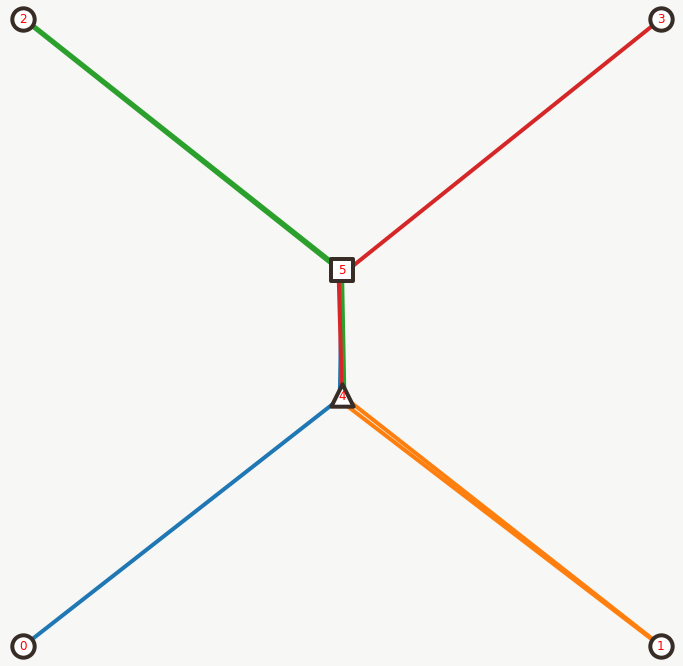

In [66]:
graph(stations, rails)

### (Mostly out-of-context thoughts) 

### Open problems and relevant discussion

Problems:

1. 'as-is' DFJ SEC in Archetti et al. didn't work, in part because you 'want' some of the kinds of subtour behaviour (customer-to-customer) that it is trying to stop.
    - PATH 1 (implemented): Use MTZ SEC's instead
    - PATH 2a: Allow the subtour if the subset exactly matches with a current vehicle route (quantified by `|S| == sum(x[i,j,v] for i in S for j in S) for any v in V`). Be careful to allow 'subtours' that connect to the depot, but not 'subtours' that ignore the depot.
    - PATH 2b: Use disjunctive ideas to deactivate the |S|-1 constraint in such a situation.
        - SOLN IDEA: the constr is `(E(S,v) <= |S| - 1 + 10e6*(E(S,v) == E(v))`
        - OR set `f[s,v]` integer and constrain with `f[s,v] <= E[v] - E[s,v]`


2. Loops, while permissible upon a solution to (P1) are not optimal, as it is always cheaper to just form a straight route and then go back to dummy-depot.
    - NOTE: It is easily verified that loops are now allowed by setting the cost matrix to be 100% negative, encouraging as long a path as it can have (which is `N_STATIONS+1`). Not very tractable for gurobi though


3. Actual optimisation for MM goals (high station diversity, all-types-reachable). I suspect the 'demand satisfaction' idea can effectively be chucked with zero consequences. Heuristic arguments can be used to motivate these issues.


4. My drafted algorithm is slow for 3-cluster (i.e. `N_STATIONS=12`) where the clusters were forced to connect; more constraints may hinder this. Regardless, some optimisations to the solution procedure, perhaps in the Tabu paper or hinted at in the survey, may be important for pushing forward.


5. Ignoring what I've done, there's an awful lot of 'many-paths-work' once you utilise dummy depots. Ant, nonfixed MmTSP, SDVRP, all can work. So it's a matter of choice.
- Caveat I've noticed: Ant can be well-enough adapted to allow loops IF you set up TWO dummy depots... otherwise you have to kill (8). It's been causing problems for me
> Apologies, but while I'm confident the SDVRP-based will not form bad subtours, I can't remember the reasoning

6. If costs satisfy triangle inequality, the SDVRP optimals have one overlapping customer, max. This would allow another constraint, that each edge can only be crossed by one train max (though that violates some play strategy in MM).
    - (but what if d >>>> Q?)
    - I conjecture it is true for MM since d(a,b) - |b-a| is upper-bounded at ~9% of ||b-a|| and any 3 points will have a corresponding 'convex' path

Random:

- Allowing boosted train capacity (since carriages possible)
- `hexagon` + biased demand weights == easy check that overlap is okay
- `loop_feasibility` + negative costs == easy check that loops are okay 
- `donut` == easy check for a problem that needs a loop solution

# Stage 2 - Brute-Force

In [67]:
import networkx as nx

def cost(rails):
    # Find distance between all pairs of stations
    G=nx.Graph()

    elist = []
    for rail in rails:
        start = rail[0]
        for end in rail[1:]:
            elist.append((start, end, dist[start.id, end.id]))
            start = end    

    G.add_weighted_edges_from(elist)
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    # For each starting station
    for start, paths in all_paths:

        distances = {kind: 1e12 for kind in all_kinds}

        # Get its kind
        for end, path in paths.items():
            # For each other station: If kind is different
            if start.kind != end.kind:
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], total_distance(path))

        station_dists.append(sum(distances.values()))

    return sum(station_dists)

In [68]:
from math import factorial
from itertools import permutations
from tqdm import tqdm

def brute_force_tsp(stations):
    max_dist = 1e15
    best = None

    for perm in tqdm(permutations(stations), total=factorial(N_STATIONS)):
        perm = list(perm)
        perm.append(perm[0])
        perm = [perm]
        
        dist = cost(perm)
        if dist < max_dist:
            max_dist = dist
            best = perm
            
    return best

a = brute_force_tsp(stations)

100%|██████████████████████████████████████████████████████████████████████████████| 720/720 [00:00<00:00, 4528.45it/s]


In [69]:
a

[[<0>, <1>, <4>, <5>, <2>, <3>, <0>]]

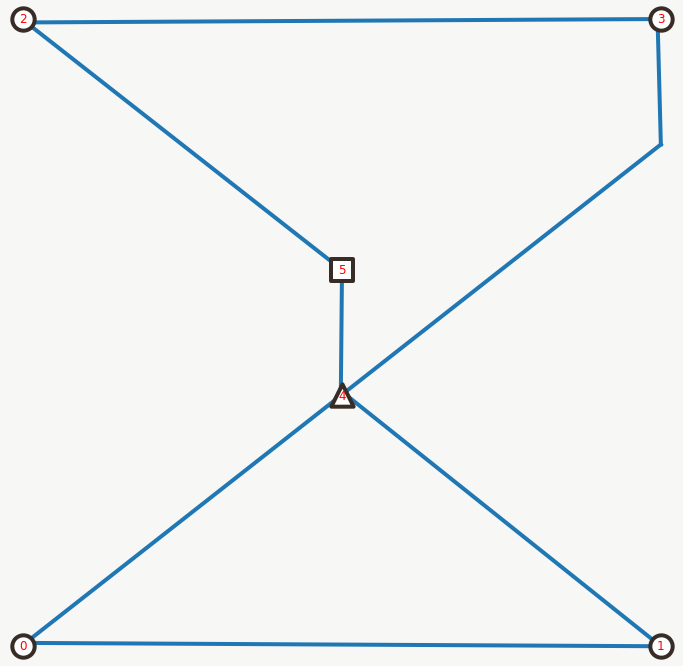

In [70]:
graph(stations, a)

In [71]:
from math import factorial

def brute_force_tsp(stations):
    ''' This doesn't allow for loops or overlapping sections but it should '''
    max_dist = 1e15
    best = None

    for perm in tqdm(permutations(stations), total=factorial(N_STATIONS)):
        perm = list(perm)
        perm.append(perm[0])
        for split in range(2, len(perm)):
            split = [perm[:split], perm[split:]] 

            dist = cost(split)
            if dist < max_dist:
                max_dist = dist
                best = split
            
    return best

a = brute_force_tsp(stations)

100%|███████████████████████████████████████████████████████████████████████████████| 720/720 [00:00<00:00, 871.68it/s]


In [72]:
a

[[<0>, <1>], [<2>, <3>, <5>, <4>, <0>]]

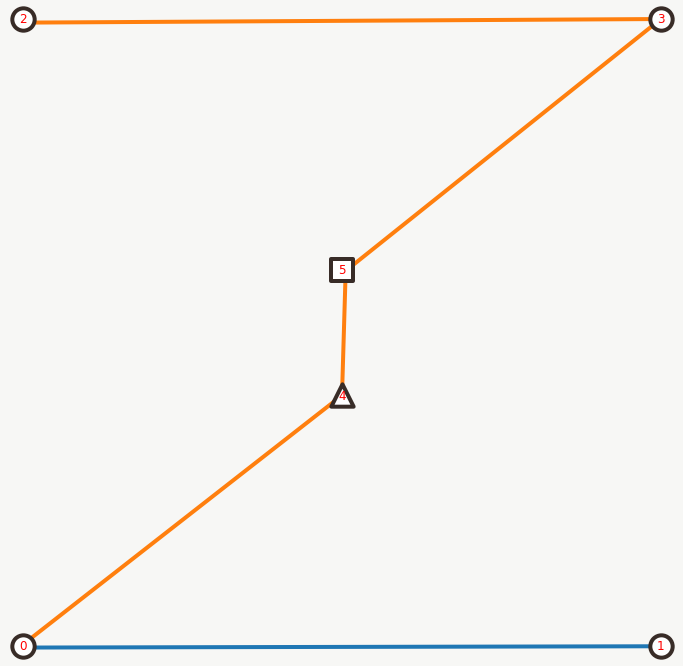

In [73]:
graph(stations, a)

# Metaheuristics

In [74]:
from numpy.random import shuffle, randint, choice
from copy import deepcopy

def initialise(N, K):
    x = np.zeros((N, N, K))
    
    order = list(range(N))
    
    for k in range(K):
        shuffle(order)
        for i in range(N-1):
            a = order[i]
            b = order[i+1]
            x[a, b, k] = x[b, a, k] = 1
            
    return x      

isolated_station = lambda x: not all(x.sum(axis=2).sum(axis=0))
rail_covers_every_station = lambda grid: not any(grid.sum(axis=0) == 0)
has_loop = lambda grid: not any(grid.sum(axis=0) == 1)
just_two_stations = lambda grid: (grid.sum() == 2)
get_stations_not_on_line = lambda grid: (grid.sum(axis=0) == 0).nonzero()[0]
get_middle_stations = lambda grid: (grid.sum(axis=0) == 2).nonzero()[0]
get_end_stations    = lambda grid: (grid.sum(axis=0) == 1).nonzero()[0]
get_line_stations   = lambda grid: (grid.sum(axis=0) != 0).nonzero()[0]
has_subtours = lambda grid: len(get_end_stations(grid)) > 2

def get_neighbour(x, case=0):
    x = deepcopy(x)
    # How many lines to modify
    m = 1 + randint(x.shape[2])
    
    lines = list(range(x.shape[2]))
    shuffle(lines)
    
    lines_to_modify = lines[:m]
    
    for k in lines_to_modify:
        grid = x[:, :, k]
        
        case = choice([1, 2, 3, 4]) if case == 0 else case
        
        if case == 1:
            # Case 1. Expand Rail line end (Includes forming loop)
            if not has_loop(grid):
                old_choices = list(get_end_stations(grid))
                new_choices = list(get_stations_not_on_line(grid)) + old_choices
                
                old = choice(old_choices)
                new = choice(new_choices)
                
                if new != old:
                    grid[old, new] = grid[new, old] = 1

        elif case == 2:
            # Case 2. Shrink Rail line end (Includes breaking loop)
            # This can make city invalid (considering station kinds)
            # But cost function makes the cost really high
            if has_loop(grid):
                # Pick edge to break
                choices = np.array(grid.nonzero()).T
                i, j = choices[choice(range(len(choices)))]
                grid[i, j] = grid[j, i] = 0
            else:
                # Pick end to shrink
                ends = get_end_stations(grid)
                old_end = choice(ends)
                new_end = grid[old_end, :].argmax()
                grid[old_end, new_end] = grid[new_end, old_end] = 0

                if isolated_station(x):
                    grid[old_end, new_end] = grid[new_end, old_end] = 1

        elif case == 3:
            # Case 3. Add station in middle
            if not rail_covers_every_station(grid):
                choices = get_stations_not_on_line(grid)
                b = choice(choices)
                
                a = choice(get_line_stations(grid))
                c = grid[a].nonzero()[0]
                
                grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 1
                grid[a, c] = grid[c, a] = 0

        elif case == 4:
            # Case 4. Remove station in middle
            # If not just 2 stations
            if not just_two_stations(grid):
                choices = get_middle_stations(grid)
                b = choice(choices)
                a, c = grid[b, :].nonzero()[0]
                grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 0
                prev_ac = grid[a, c]
                grid[a, c] = grid[c, a] = 1

                if isolated_station(x):
                    grid[a, b] = grid[b, a] = grid[b, c] = grid[c, b] = 1
                    grid[a, c] = grid[c, a] = prev_ac
        
    return x


import networkx as nx
from networkx import from_numpy_matrix

M = 1e5

def cost(stations, x):
    connections = 1 * (x.sum(axis=2) > 0)
    dist = gen_distance_matrix(city).round(2)
    # weighted_adjacency is edge weight where edge exists, else 0
    weighted_adjacency = connections * dist
    G = from_numpy_matrix(weighted_adjacency)
    
    all_paths = list(nx.all_pairs_shortest_path(G))
    
    station_dists = []
    all_kinds = {s.kind for s in stations}

    # For each starting station
    for i, paths in all_paths:
        start = stations[i]

        distances = {kind: M for kind in all_kinds if kind != start.kind}

        # Get its kind
        for j, path in paths.items():
            end = stations[j]
            # For each other station: If kind is different
            if start.kind != end.kind:
                rails = [stations[i] for i in path]
                # Work out distance to that station and retain if min
                distances[end.kind] = min(distances[end.kind], total_distance(rails))

        station_dists.append(sum(distances.values()))
        
    return sum(station_dists) + len(G.edges) / M


In [75]:
x1 = np.array([
[[0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [1, 0, 0, 0, 0, 1],
 [0, 0, 0, 1, 1, 0]],
[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1],
 [0, 0, 1, 0, 1, 0]]
]).transpose(2, 1, 0)

x1[:, :, 0]

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 1, 0]])

In [76]:
x2 = np.array([
[[0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1],
 [1, 0, 0, 0, 1, 0]],
[[0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 1],
 [0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0]]
]).transpose(2, 1, 0)

x2[:, :, 0]

array([[0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 1, 0]])

34.284321247461904


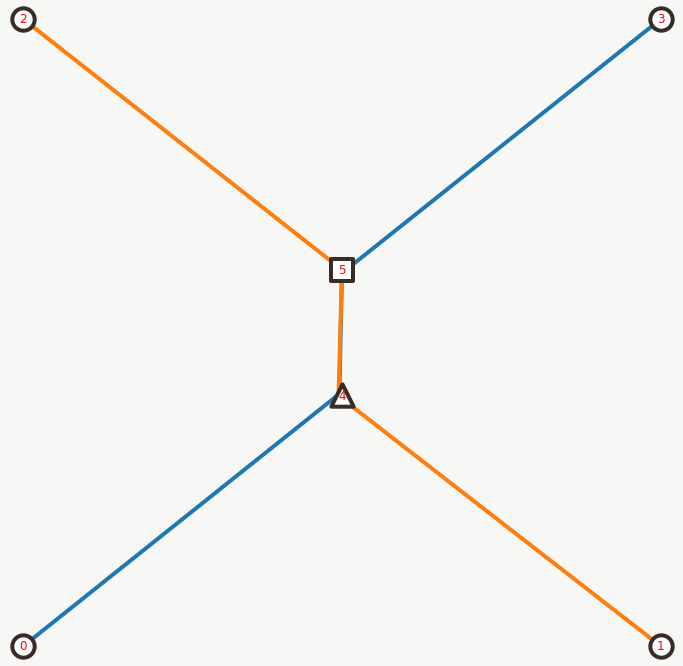

In [77]:
print(cost(city.stations, x1))

graph_x(city.stations, x1)

36.284321247461904


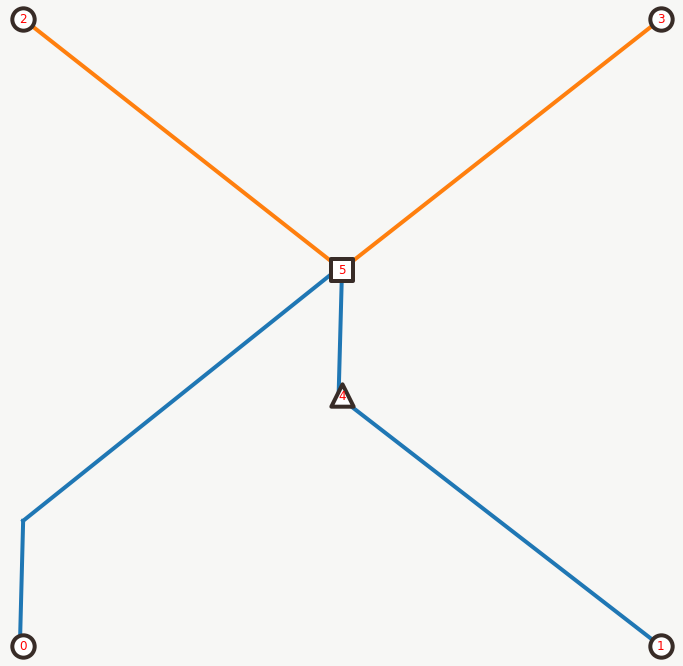

In [78]:
print(cost(city.stations, x2))

graph_x(city.stations, x2)

36.284321247461904


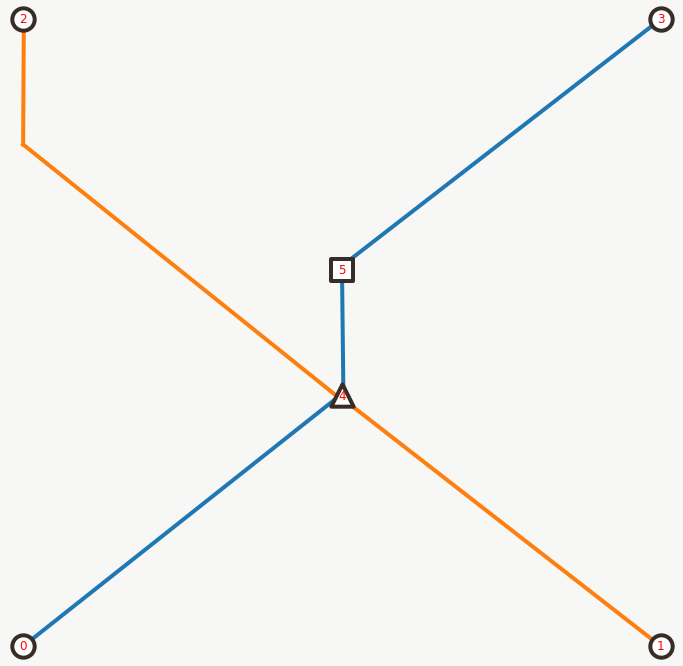

In [79]:
nn = get_neighbour(x1)

print(cost(city.stations, nn))

graph_x(city.stations, nn)

# Simulated Annealing

In [80]:
def simulated_annealing(stations, K):
    ''' Performs simulated annealing to find (try and find) the optimal configuration 
        K is number of lines '''
    # Initialise Configuration
    cur_x = initialise(len(stations), K)
    cur_cost = cost(stations, cur_x)
    best_x, best_cost = cur_x, cur_cost
    
    # Maximum iterations
    max_iter = 100
    CUTOFF_VAL = 0.001
    
    # Time
    t = 0
    
    while True:
        # Update current temperature
        T = np.exp(np.log(CUTOFF_VAL)*t / max_iter)
        if T < CUTOFF_VAL:
            # Return configuration and its value
            return best_x, best_cost
        
        # Make random change
        new_x = get_neighbour(cur_x)
        new_cost = cost(stations, new_x)
        
        # Keep change if it is an improvement (or randomly sometimes)
        if new_cost < cur_cost or np.random.uniform(0, 1) < T:
            cur_x, cur_cost = new_x, new_cost
            
            if cur_cost < best_cost:
                best_x, best_cost = cur_x, cur_cost
            
        t += 1
        
best_x, best_cost = None, M
for restart in tqdm(range(1)):
    res_x, res_cost = simulated_annealing(city.stations, K=2)
    if res_cost < best_cost:
        best_x, best_cost, res_x, res_cost
        print(best_cost)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.52it/s]

100000.0


# Computational Studies

In [81]:
from time import time
from tqdm import tqdm

def experiment(n_stations_range, num_trials, formulation, verbose=True):
    
    # Store results
    res_n_stations = []
    res_time_taken = []
    
    iterator = tqdm(n_stations_range) if verbose else n_stations_range
    
    for n_stations in iterator:
        for _ in range(num_trials):
            
            t0 = time()
            formulation(City(n_stations), verbose=False)
            t1 = time()
            
            res_n_stations.append(n_stations)
            res_time_taken.append(t1 - t0)
            
    return res_n_stations, res_time_taken

In [83]:
tsp_n_stations, tsp_time_taken = experiment(range(2, 18), 5, tsp)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:34<00:00,  5.93s/it]


In [84]:
sdvrp_n_stations, sdvrp_time_taken = experiment(range(2, 9), 5, sdvrp)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:00<00:00,  8.67s/it]


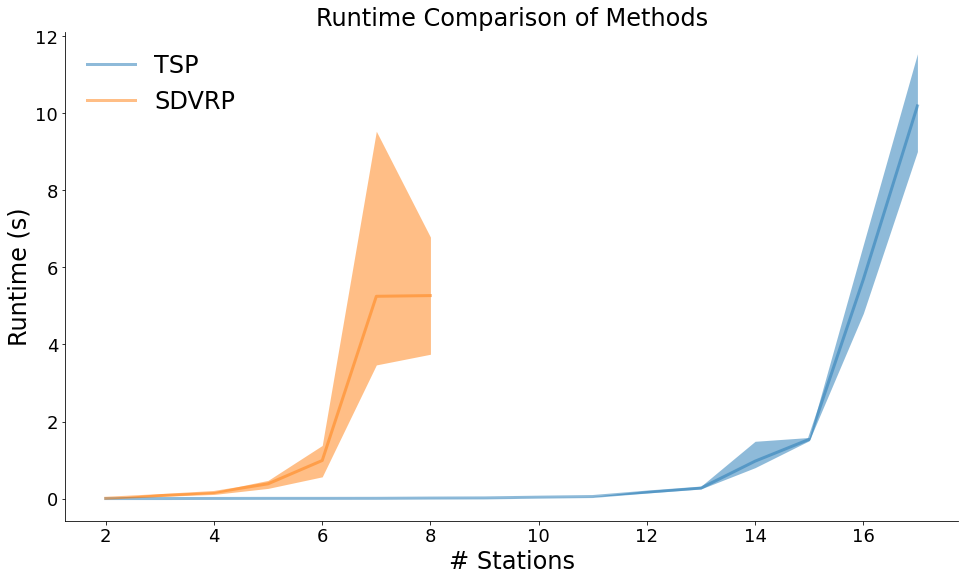

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import defaultdict

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

fig, ax = plt.subplots(figsize=(16, 9))

results = {'TSP': (tsp_n_stations, tsp_time_taken), 'SDVRP': (sdvrp_n_stations, sdvrp_time_taken)}

def get_sum_stats(x, y):
    vals = defaultdict(list)
    
    for x_, y_ in zip(x, y):
        vals[x_].append(y_)
        
    xs = []
    means = []
    sds = []
    mins = []
    maxs = []
    for x, ys in vals.items():
        ys = np.array(ys)
        xs.append(x)
        means.append(ys.mean())
        sds.append(ys.std())
        mins.append(ys.min())
        maxs.append(ys.max())
        
    return np.array(xs), np.array(means), np.array(sds), np.array(mins), np.array(maxs)

for i, (name, (res_n_stations, res_tsp_time_taken)) in enumerate(results.items()):
    col = f'C{i}'
    #ax.scatter(res_n_stations, res_tsp_time_taken, alpha=0.3, color=col)
    xs, means, sds, mins, maxs = get_sum_stats(res_n_stations, res_tsp_time_taken)
    ax.plot(xs, means, lw=LW, alpha=0.5, color=col, label=name)
    ax.fill_between(xs, mins, maxs, lw=0, alpha=0.5, color=col)

ax.set_title('Runtime Comparison of Methods')
ax.set_xlabel('# Stations')
ax.set_ylabel('Runtime (s)')

ax.legend(frameon=False)

sns.despine()

plt.show()

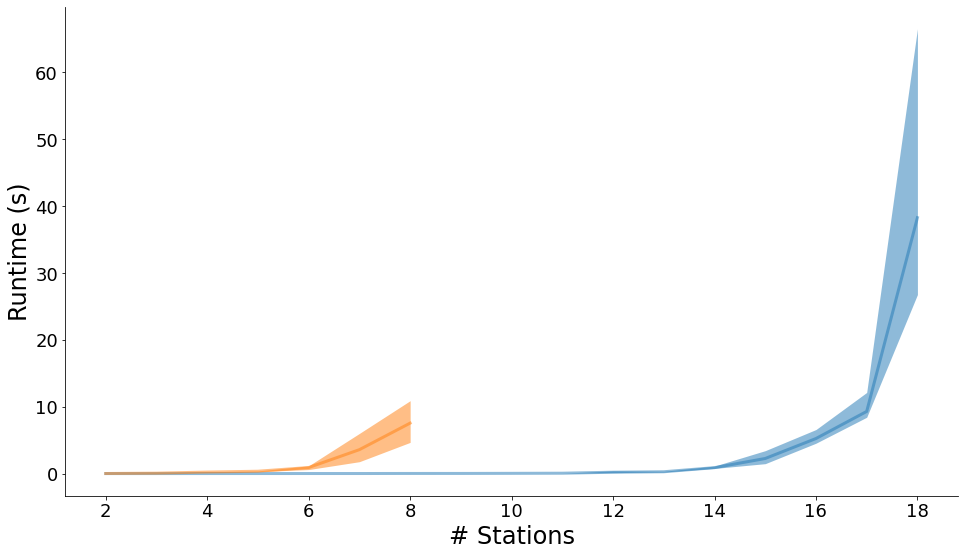

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import defaultdict

SMALL, MED, LARGE, LW = 18, 24, 30, 3
plt.rc('axes', titlesize=MED)    # fontsize of the axes title
plt.rc('axes', labelsize=MED)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL) # fontsize of the tick labels
plt.rc('legend', fontsize=MED)   # legend fontsize
plt.rc('font', size=LARGE)       # controls default text sizes

fig, ax = plt.subplots(figsize=(16, 9))

results = {'TSP': (tsp_n_stations, tsp_time_taken), 'SDVRP': (sdvrp_n_stations, sdvrp_time_taken)}

def get_sum_stats(x, y):
    vals = defaultdict(list)
    
    for x_, y_ in zip(x, y):
        vals[x_].append(y_)
        
    xs = []
    means = []
    sds = []
    mins = []
    maxs = []
    for x, ys in vals.items():
        ys = np.array(ys)
        xs.append(x)
        means.append(ys.mean())
        sds.append(ys.std())
        mins.append(ys.min())
        maxs.append(ys.max())
        
    return np.array(xs), np.array(means), np.array(sds), np.array(mins), np.array(maxs)

for i, (name, (res_n_stations, res_tsp_time_taken)) in enumerate(results.items()):
    col = f'C{i}'
    #ax.scatter(res_n_stations, res_tsp_time_taken, alpha=0.3, color=col)
    xs, means, sds, mins, maxs = get_sum_stats(res_n_stations, res_tsp_time_taken)
    ax.plot(xs, means, lw=LW, alpha=0.5, color=col, label=name)
    ax.fill_between(xs, mins, maxs, lw=0, alpha=0.5, color=col)

ax.set_title('Runtime Comparison of Methods')
ax.set_xlabel('# Stations')
ax.set_ylabel('Runtime (s)')

ax.legend(frameon=False)

sns.despine()

plt.show()